In [1]:
#pip install h5py nibabel pandas glob2 regex
import numpy as np
import matplotlib.pyplot as plt
import h5py
import nibabel as nib
import scipy.io
import time
import pandas as pd
import glob
import re

from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product

In [2]:
#sub = '3DMRSIMAP_Vol_05_A_1_2024-09-02_L2_0p0005'
#sub = '3DMRSIMAP_Vol_06_A_1_2024-08-22_L2_0p0005'
sub = '3DMRSIMAP_Vol_09_A_1_2024-09-03_L2_0p0005'
#sub = '3DMRSIMAP_Vol_10_A_1_2024-09-04_L2_0p0005'

# path
p = '/workspace/walinet/PaulTrainData/'+sub+'/TESTING_beforeLipid.mat'
p_wat = '/workspace/walinet/PaulTrainData/'+sub+'/WaterReference.mat'

# Water Removal
b_RemWat = True
WatSuppComp = 32 # Number of component for the HSVD water removal (advised: 16 at 3T and 32 at 7T)
minFreq = -150 # -150Hz(7T) # +-0.5ppm
maxFreq = 150 # 150
parallel_jobs = 20

bandwidth = 3000 # 3khz
dwell_time = 1/bandwidth

In [3]:
fh = h5py.File(p,'r')
csi_crrrt = np.array(fh['csi'])
csi_crrrt = csi_crrrt['real']+1j*csi_crrrt['imag']
csi_crrrt = np.transpose(csi_crrrt, axes=(4,3,2,1,0)) # (32, 64, 64, 39, 960) (coils, xdim, ydim, slices, time)

mask = np.array(fh['mask'])
mask = np.transpose(mask, axes=(2,1,0))
headmask = np.ones((64,64,39))


fh_wat = scipy.io.loadmat(p_wat)
weights = fh_wat['weights']  # (32, 64, 64, 39) (coils, xdim, ydim, slices)

In [4]:
############################
##### Coil Combination #####
############################

csi_rrrt = np.sum(csi_crrrt * weights[:,:,:,:,None], axis=0)


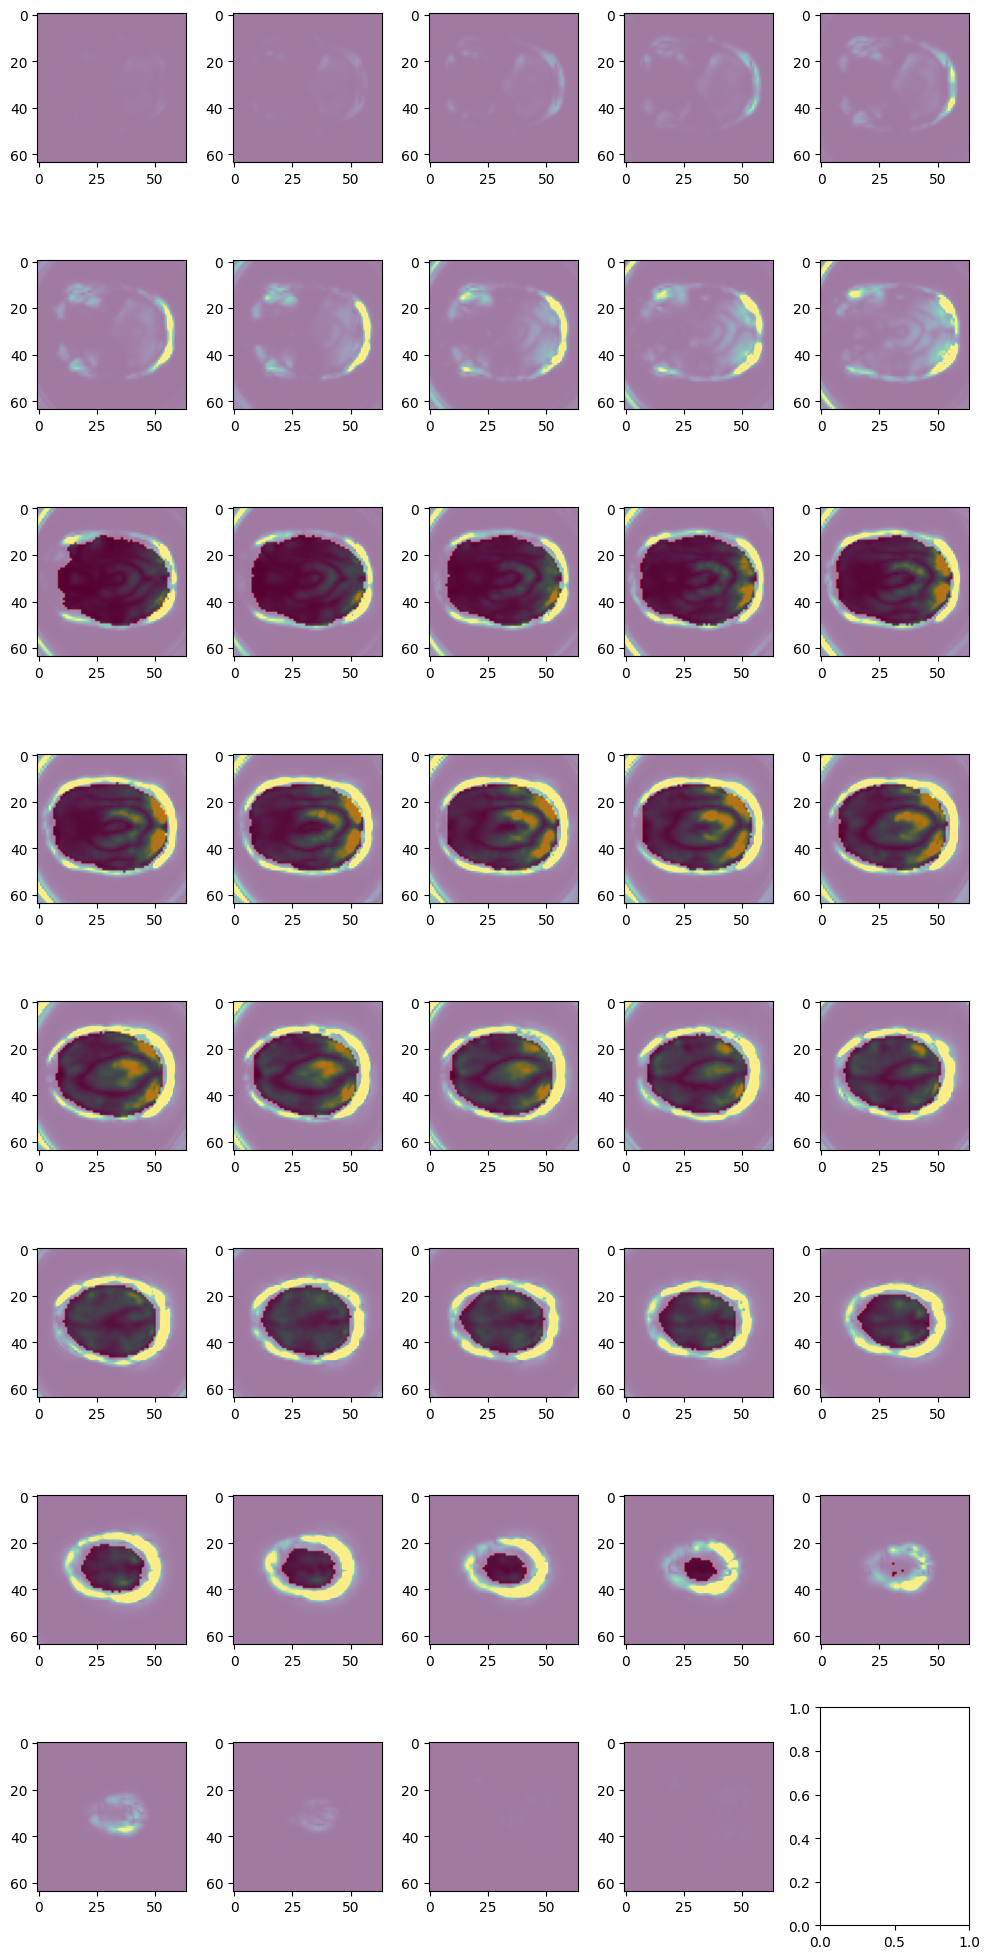

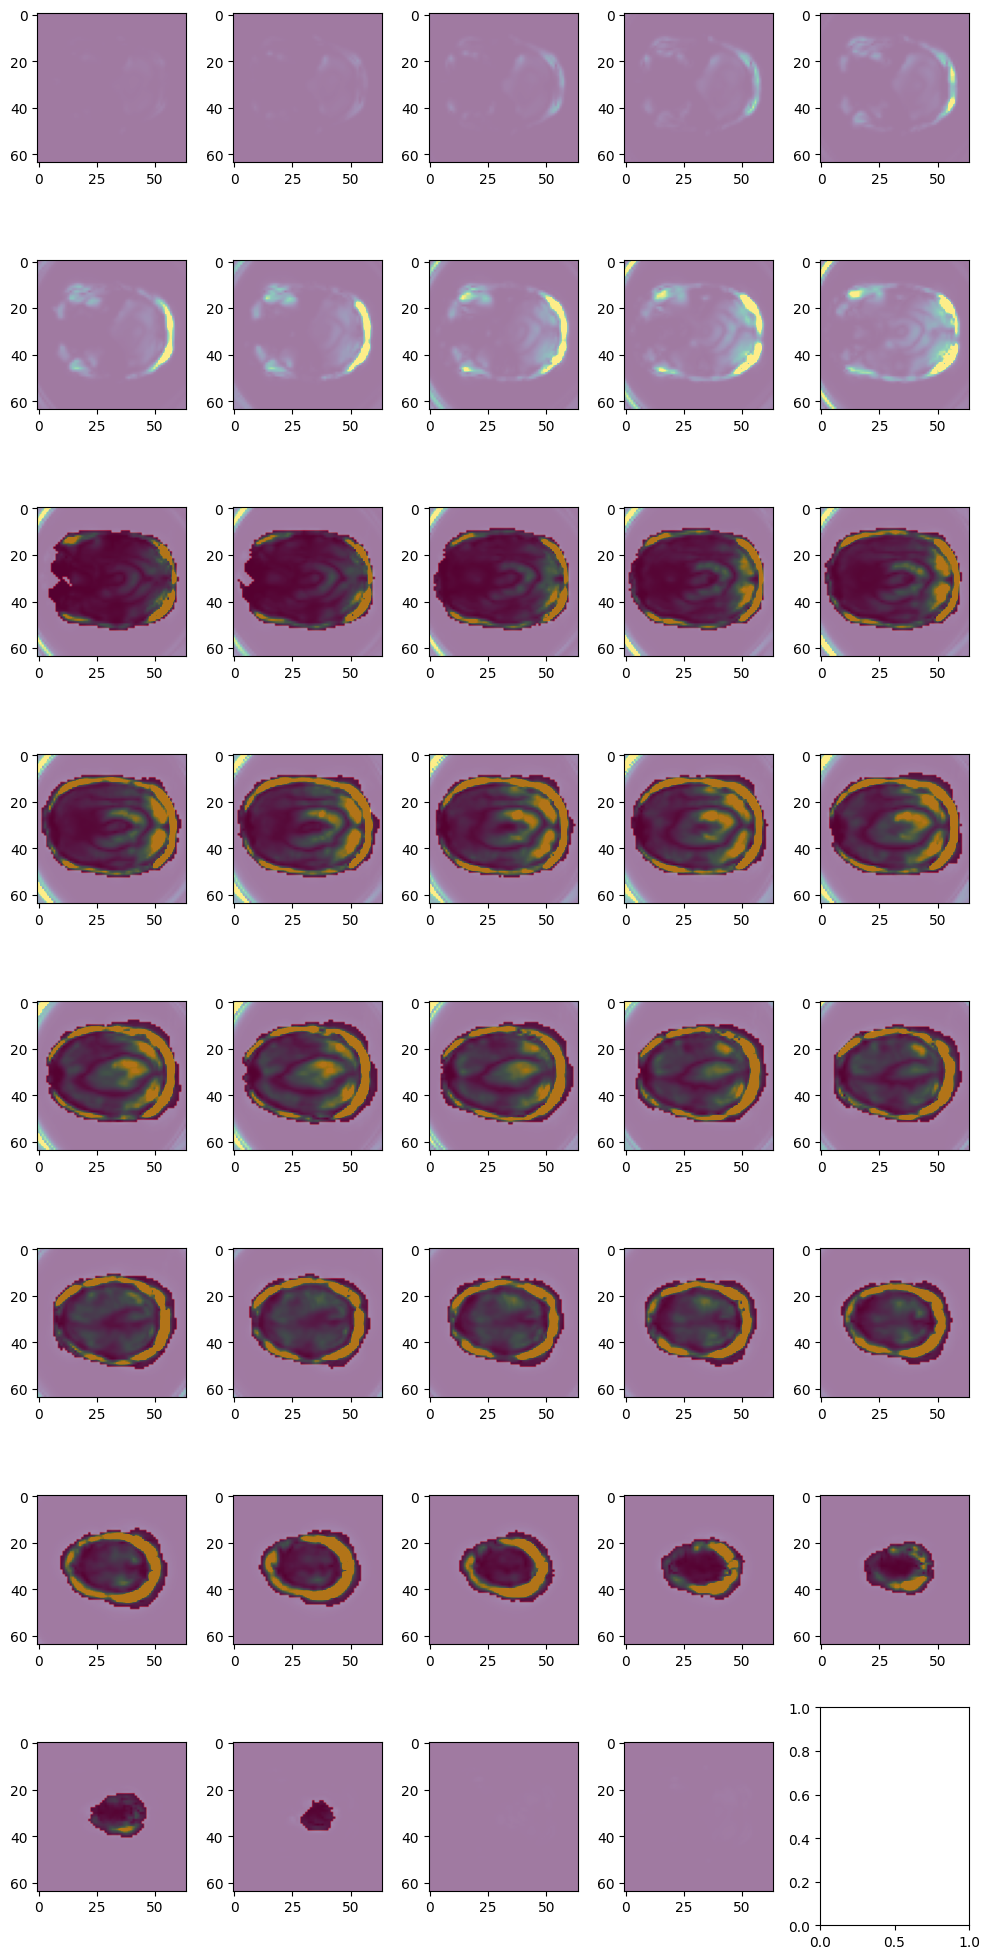

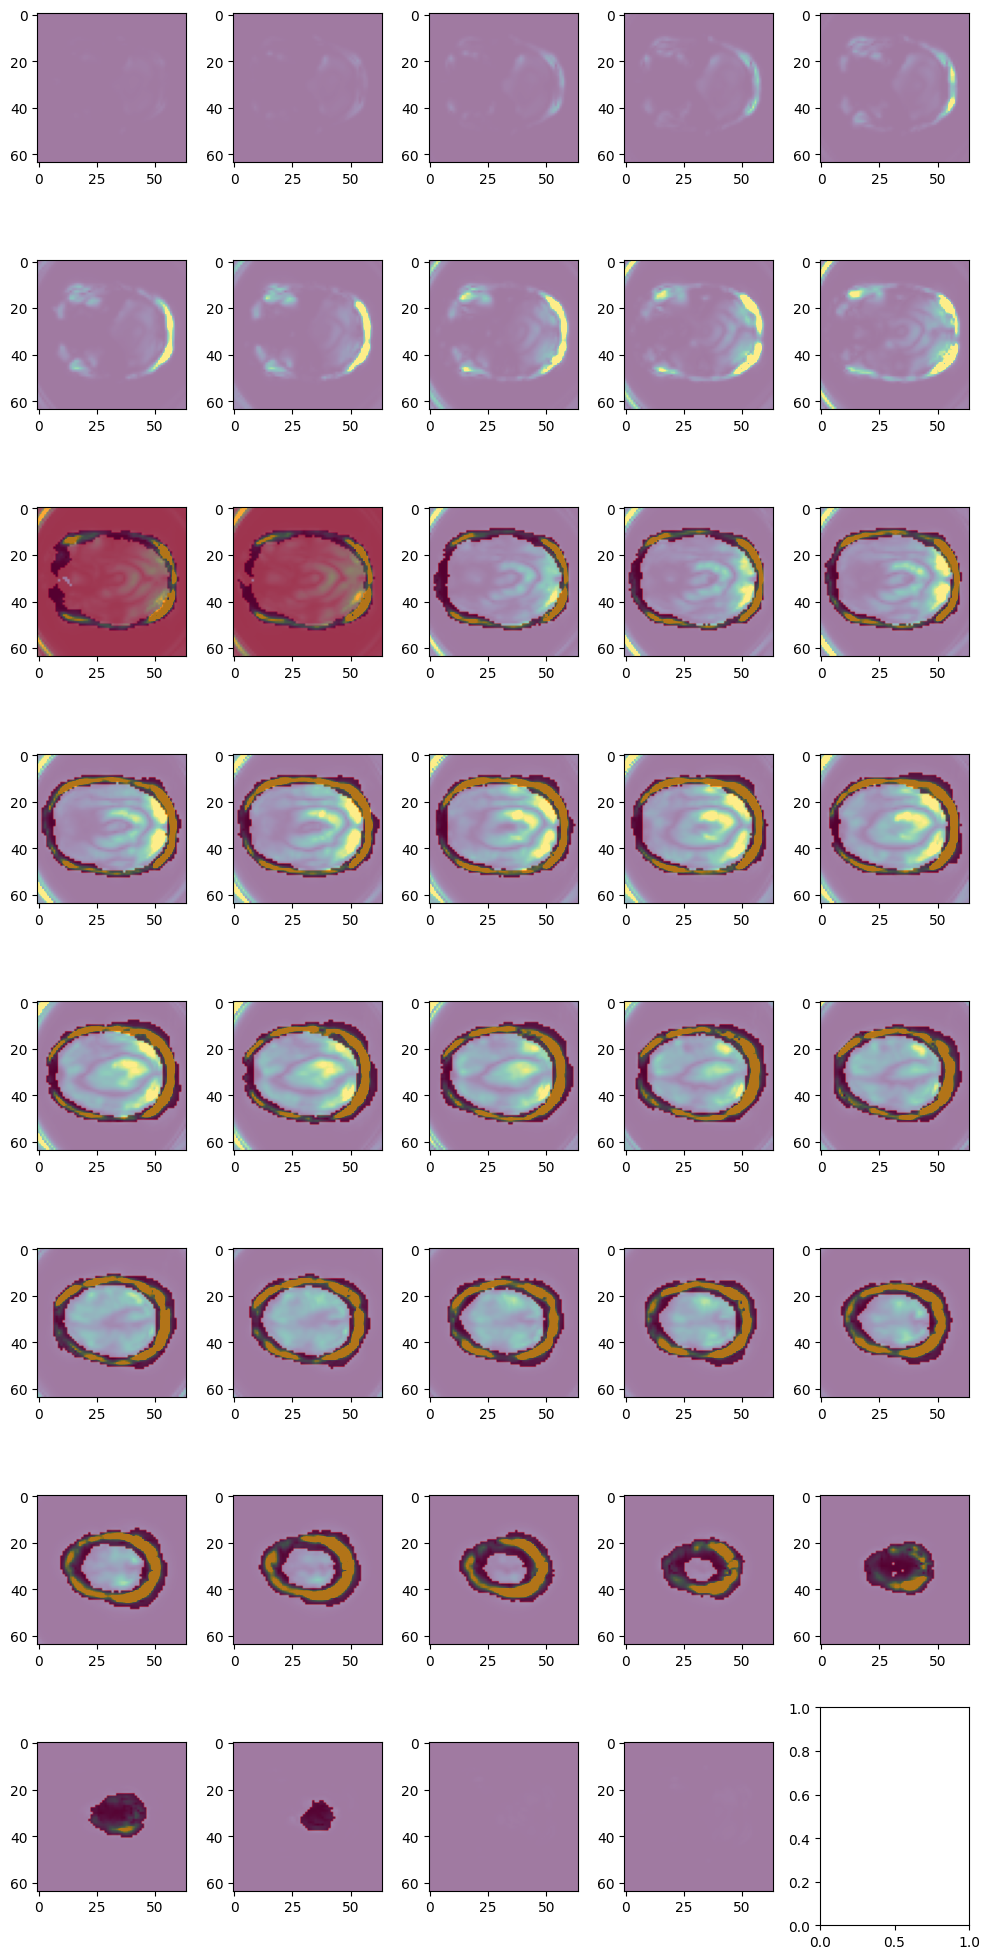

In [5]:
###########################
##### Mask Generation #####
###########################


### Brainmask ###
brainmask = mask
brainmask[:,:,:10]=0

if True:
    nuisance_rrr = np.sum(np.abs(csi_rrrt), axis=-1)
    fig, ax = plt.subplots(8, 5, figsize=(10,20))
    for i in range(8):
        for ii in range(5):
            sl = i*5 + ii
            if sl<39:
                ax[i,ii].imshow(nuisance_rrr[:,:,sl], vmax=12570230000000)
                ax[i,ii].imshow(brainmask[:,:,sl], cmap='Reds', alpha=0.5)
    fig.tight_layout()
    plt.show()



### Headmask ###
nuisance_rrr = np.sum(np.abs(csi_rrrt), axis=-1)

x, y = np.indices((64, 64))
circ = (x-32)**2+(y-32)**2
thresh = 1000
circ[circ<=thresh]=1
circ[circ>thresh]=0

headmask = circ[:,:,None]*nuisance_rrr

thresh2 = 9*10**11
headmask[headmask<thresh2] = 0
headmask[headmask>=thresh2] = 1

pad=10
ite=8
for sl in range(39):
    tmp = headmask[:,:,sl]
    tmp = np.pad(tmp, [(pad, pad), (pad, pad)])
    tmp = scipy.ndimage.binary_dilation(tmp, iterations=ite)
    tmp = scipy.ndimage.binary_erosion(tmp, iterations=ite)
    headmask[:,:,sl] += tmp[pad:-pad,pad:-pad]
headmask[headmask>=1]=1

pad=10
ite=8
tmp = headmask
tmp = np.pad(tmp, [(pad, pad), (pad, pad), (pad, pad)])
tmp = scipy.ndimage.binary_dilation(tmp, iterations=ite)
tmp = scipy.ndimage.binary_erosion(tmp, iterations=ite)
headmask += tmp[pad:-pad,pad:-pad,pad:-pad]
headmask[headmask>=1]=1

headmask[:,:,:10]=0

if True:
    fig, ax = plt.subplots(8, 5, figsize=(10,20))
    for i in range(8):
        for ii in range(5):
            sl = i*5 + ii
            if sl<39:
                ax[i,ii].imshow(nuisance_rrr[:,:,sl], vmax=12570230000000)
                ax[i,ii].imshow(headmask[:,:,sl], cmap='Reds', alpha=0.5)
    fig.tight_layout()
    plt.show()

skmask = headmask - brainmask
skMask[skMask<0]=0
if True:
    fig, ax = plt.subplots(8, 5, figsize=(10,20))
    for i in range(8):
        for ii in range(5):
            sl = i*5 + ii
            if sl<39:
                ax[i,ii].imshow(nuisance_rrr[:,:,sl], vmax=12570230000000)
                ax[i,ii].imshow(skmask[:,:,sl], cmap='Reds', alpha=0.5)
    fig.tight_layout()
    plt.show()

In [ ]:
#########################
##### Water Removal #####
#########################

def HSVD(y, fs, k):
    N = len(y)
    L = int(np.floor(0.5*N))

    # Hankel Matric and SVD
    H = scipy.linalg.hankel(y[:L], y[L:N])
    u, s, vh = np.linalg.svd(H)

    # Compute Z prime
    Uk = u[:,:k]
    Ukt = Uk[1:,:]
    Ukb = Uk[:-1,:]
    Zp = np.matmul(np.linalg.pinv(Ukb),Ukt)

    # Compute poles
    w, v = np.linalg.eig(Zp)
    Z = np.matmul(np.matmul(np.linalg.inv(v), Zp), v)
    q = np.log(np.diag(Z))
    dt = 1/fs
    dampings = np.real(q)/dt
    dampings[dampings>10] = 10
    frequencies = np.imag(q)/(2*np.pi)/dt

    # Construct Basis
    t = np.arange(start=0,stop=len(y)*dt,step=dt)
    basis = np.exp(np.matmul(t[:,None], (dampings+2*np.pi*1j*frequencies)[None,:]))

    # Compute the amplitude estimates
    amps = np.matmul(np.linalg.pinv(basis),y)
    return frequencies, dampings, basis, amps

if b_RemWat:
    print("####### Water Suppression #######")
    sta_time = time.time()

    image_grid = np.array(csi_rrrt)
    s = image_grid.shape
    image_rrrt = np.zeros(image_grid.shape, dtype=np.complex64)
    water_rrrt = np.zeros(image_grid.shape, dtype=np.complex64)


    def WaterSuppressionWrapper(image_rrrt, mask, fs, k, minFreq, maxFreq):
        global WaterSuppression
        def WaterSuppression(tup):
            (x,y,z)=tup
            fid = image_rrrt[x,y,z,:] 
            if mask[x,y,z]:
                #sta_time = time.time()
                frequencies, dampings, basis, amps = HSVD(y = fid,
                                                        fs = fs,
                                                        k = k)
                indx = np.where(np.logical_and(frequencies >= minFreq, maxFreq >= frequencies))[0]
                filtFid = fid - np.sum(np.matmul(basis[:,indx], np.diag(amps[indx])), 1)

                return (filtFid, x,y,z, np.sum(np.matmul(basis[:,indx], np.diag(amps[indx])), 1))
        return WaterSuppression

    WaterSuppression = WaterSuppressionWrapper(image_rrrt = image_grid, 
                                                mask = headmask,
                                                fs = 1/dwell_time, 
                                                k = WatSuppComp, 
                                                minFreq = minFreq, 
                                                maxFreq = maxFreq)

    all_sl = list(range(s[2]))
    i=0
    slices = []
    cur_tup = []
    while i < s[2]:
        if len(cur_tup) < 3-1 and i<s[2]-1:
            cur_tup.append(all_sl[i])
        else:
            cur_tup.append(all_sl[i])
            slices.append(tuple(cur_tup))
            cur_tup = []
        i+=1

    #print("all slices: ", slices)
    #slices=[(20,)]
    for sl in slices:
        print("Slice: ", sl)
        res = Parallel(n_jobs=parallel_jobs)(delayed(WaterSuppression)(tup=tup)
                            for tup in tqdm(product(range(s[0]), range(s[1]), sl), total=s[0]*s[1]*len(sl), position=0, leave=True))

        for tup in res:
            if tup is not None:
                filtFid, x, y, z, waterFid= tup
                image_rrrt[x,y,z] = filtFid
                water_rrrt[x,y,z] = waterFid

    sto_time = time.time()
    print('Water Removal: ', sto_time-sta_time)


####### Water Suppression #######
Slice:  (0, 1, 2)


100%|████████████████████████████████████████████████████████████████████████| 12288/12288 [00:04<00:00, 2834.51it/s]


Slice:  (3, 4, 5)


100%|████████████████████████████████████████████████████████████████████████| 12288/12288 [00:02<00:00, 4748.85it/s]


Slice:  (6, 7, 8)


100%|████████████████████████████████████████████████████████████████████████| 12288/12288 [00:02<00:00, 5424.96it/s]


Slice:  (9, 10, 11)


100%|█████████████████████████████████████████████████████████████████████████| 12288/12288 [01:04<00:00, 191.93it/s]


Slice:  (12, 13, 14)


100%|█████████████████████████████████████████████████████████████████████████| 12288/12288 [01:39<00:00, 123.05it/s]


Slice:  (15, 16, 17)


100%|█████████████████████████████████████████████████████████████████████████| 12288/12288 [01:42<00:00, 120.03it/s]


Slice:  (18, 19, 20)


100%|█████████████████████████████████████████████████████████████████████████| 12288/12288 [01:38<00:00, 124.45it/s]


Slice:  (21, 22, 23)


100%|█████████████████████████████████████████████████████████████████████████| 12288/12288 [01:33<00:00, 131.10it/s]


Slice:  (24, 25, 26)


100%|█████████████████████████████████████████████████████████████████████████| 12288/12288 [01:21<00:00, 150.22it/s]


Slice:  (27, 28, 29)


100%|█████████████████████████████████████████████████████████████████████████| 12288/12288 [01:00<00:00, 204.80it/s]


Slice:  (30, 31, 32)


100%|█████████████████████████████████████████████████████████████████████████| 12288/12288 [00:43<00:00, 280.52it/s]


Slice:  (33, 34, 35)


 63%|██████████████████████████████████████████████▎                           | 7700/12288 [00:08<00:08, 538.82it/s]

In [ ]:
xdim=33
ydim=29
zdim=21


plt.plot(np.abs(np.fft.fftshift(np.fft.fft(image_grid[xdim,ydim,zdim,:]))))
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(water_rrrt[xdim,ydim,zdim,:]))))
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(image_rrrt[xdim,ydim,zdim,:]))))
plt.show()
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(image_rrrt[xdim,ydim,zdim,:]))))
plt.show()

In [ ]:
#imagesl_rrrt = image_rrrt[:,:,20,None]
#print(imagesl_rrrt.shape)

#skmasksl = skmask[:,:,20,None]
#print(skmasksl.shape)

In [ ]:
#print('####### Computing Lipid Projection Operator #######')
### Lipid Operator ###
Data_rrrf = np.fft.fftshift(np.fft.fft(image_rrrt, axis=-1), axes=-1)
#Data_rrrf = np.fft.fftshift(np.fft.fft(imagesl_rrrt, axis=-1), axes=-1)

s = Data_rrrf.shape
#beta=1E+3 * 2 #0.938
beta=1E-29 * 3 #beta=1E-24 * 3 #0.938
multBeta = 1.5
lipidFac = 0
LipidTarget = 0.995 # 0.938
lower=None

Data_rf = np.reshape(Data_rrrf, (s[0]*s[1]*s[2],s[3]))
lipid_mask = np.reshape(skmask, (s[0]*s[1]*s[2]))
#lipid_mask = np.reshape(skmasksl, (s[0]*s[1]*s[2]))

lipid_rf = Data_rf[lipid_mask>0,:]

while np.abs(lipidFac-LipidTarget) > 0.005:
    LipidRem_Operator_ff = np.linalg.inv(np.eye(s[-1]) + beta * np.matmul(np.conj(lipid_rf).T, lipid_rf))
    ## Mean vlaue of diagonal should be 1 or above 0.9
    ## 
    print("Mean Absolute Value of Diagonal of Lipid Suppression Operator: ")
    lipidFac = np.mean(np.abs(np.diagonal(LipidRem_Operator_ff)))
    print(lipidFac)
    

    if lipidFac < LipidTarget:
        beta = beta/multBeta
        if lower==False:
            multBeta=0.5*multBeta
        lower=True
    else:
        beta = beta*multBeta
        if lower==True:
            multBeta=0.5*multBeta
        lower=False

print("Mean Absolute Value of Diagonal of Lipid Suppression Operator: " + str(lipidFac))
LipidRem_Operator_ff = np.linalg.inv(np.eye(s[-1]) + beta * np.matmul(np.conj(lipid_rf).T, lipid_rf))
LipidProj_Operator_ff = np.eye(LipidRem_Operator_ff.shape[0]) - LipidRem_Operator_ff


In [ ]:
print(image_rrrt.shape)
xdim=35
ydim=29
zdim=21


plt.imshow(np.abs(image_rrrt[:,:,zdim,0]))
plt.show()

spec1 = np.fft.fftshift(np.fft.fft(image_rrrt[xdim,ydim,zdim,:]))
spec2 = np.matmul(spec1, LipidRem_Operator_ff)
spec3 = np.matmul(spec1, LipidProj_Operator_ff)


plt.plot(np.abs(spec1))
plt.plot(np.abs(spec2))
plt.plot(np.abs(spec3))
plt.show()

In [ ]:



lipid_rf = np.zeros((nSpectra, N), dtype=np.complex64)
nRandomLipid=10
MaxLipidScaling=70

imagesl_rrrf = np.fft.fftshift(np.fft.fft(imagesl_rrrt,axis=-1),axes=-1)

for i in range(nSpectra):
    #indices = np.random.choice(range(int(np.sum(skmask))), size=nRandomNuisance)
    #nonzero_indices = np.nonzero(skmask)
    indices = np.random.choice(range(int(np.sum(skmasksl))), size=nRandomLipid)
    nonzero_indices = np.nonzero(skmasksl)
    xx = nonzero_indices[0][indices]
    yy = nonzero_indices[1][indices]
    zz = nonzero_indices[2][indices]
    
    #lipid_batch = image_rrrf[xx,yy,zz,:]
    lipid_batch = imagesl_rrrf[xx,yy,zz]
    #print(lipid_batch.shape)
    
    LipAmp = np.random.rand(nRandomLipid)
    LipAmp=LipAmp/np.sum(LipAmp)
    LipidPh= 2 * np.pi * np.random.rand(nRandomLipid)
    
    lipid_rf[i] = np.sum(lipid_batch * LipAmp[:,None], axis=0) #*np.exp(1j * LipidPh[:,None])


Lip_max = np.amax(np.abs(lipid_rf), axis=1)[:,None]
Metab_max = np.amax(np.abs(MetabSpectrum), axis=1)[:,None]
LipidScaling = 1e-1*(10**(np.random.rand(nSpectra, 1)*np.log10(1e1*MaxLipidScaling)))  
lipid_rf =  Metab_max/Lip_max*LipidScaling * lipid_rf

if False:
    LipTimeSerie *= np.exp(-(Time *LipWidth_Gau[ex])**2 -Time*LipWidth_Lor[ex])
    LipTimeSerie *= np.exp( Time* 1j * 2 * PI * LipFreqShift[ex] )

    #Spectra with Full Lip, Water and metab
    MaxLipidScaling=10
    LipidScaling =  1e-1*(10**(rand(NbEx, 1)*np.log10(1e1*MaxLipidScaling)))   
    Lipid_BL_Wat_Spectra[ex, :] =  BLSpectra[ex,:] + WaterSpectra[ex,:] +  Metab_max/Lip_max*LipidScaling[ex] *np.fft.fft(LipTimeSerie[:], axis=0)[N1:N2] 

    #Spectra with Removed Lip, Water and metab

    #LipidIDSpBatch[BatchI,:] =   Metab_max/Lip_max*LipidScaling[ex] *Lipid_rf_Rand[ex,:]
    LipidIDSpBatch[BatchI,:] =    Metab_max/Lip_max*LipidScaling[ex] *np.fft.fft(LipTimeSerie[:] , axis=0)

In [ ]:


MaxSNR=10
MinSNR=1

N=960
NMRFreq= 297189866.0 #127.7 *10**6 #297189866.0 #


#dwell_time = 8.3*10**(-4)  # 0.83ms
bandwidth = 3000 # 3khz
dwell_time = 1/bandwidth
sampling_rate = 1/dwell_time  # Hz  sampling_rate = 1/dwell_time

# Calculate the time vector
t = np.arange(N) / sampling_rate

# Simulation parameters
MaxAcquDelay=0.002
AcquDelay = (np.random.rand(nSpectra, 1)-0.5)*2 * MaxAcquDelay

PhShift=np.random.rand(nSpectra, 1) * 2 * np.pi
TimeSerieClean = np.zeros(( N), dtype=np.complex64)

MaxFreq_Shift = 40
FreqShift = (np.random.rand(nSpectra, 1)*2 - 1) * MaxFreq_Shift

MinPeak_Width=4
MaxPeak_Width=20
PeakWidth = MinPeak_Width + np.random.rand(nSpectra, 1) * (MaxPeak_Width - MinPeak_Width)
ponder_peaks = np.random.rand(nSpectra, 1)
PeakWidth_Gau = np.multiply(ponder_peaks, PeakWidth)
PeakWidth_Lor = np.multiply(1-ponder_peaks, PeakWidth)

SNR = MinSNR + np.random.rand(nSpectra, 1) * (MaxSNR - MinSNR)



########################################
#### Perpare metabolite information ####
########################################
def ReadModeFiles(index,list_file):
    NbM = len(list_file)
    temp_modes = [None] * NbM  # empty list of size NbM 
    for i, filename in enumerate(list_file):
        metabo_mode = pd.read_csv(filename, header=None, skiprows=[0]).values
        m = re.search("[0-9]T_.{1,6}_Exact", filename)
        name = bytes(filename[m.span()[0]+3:m.span()[1]-6].strip(), 'utf8')
        temp_modes[index[name]] = metabo_mode
    return temp_modes

index = {}  # mapping of metabolite name to index
mean_std_csv = pd.read_csv('/workspace/walinet/MetabModes/Metab_Mean_STD.txt', header=None).values

for i, v in enumerate(mean_std_csv[:, 0].astype(str)):
    index[ bytes(v.strip(), 'utf8') ] = i

mean_std = mean_std_csv[:, 1:].astype(np.float32)

list_file = glob.glob('/workspace/walinet/MetabModes/7T_TE0/*Exact_Modes.txt')
NbM = len(list_file)
metabo_modes = [[[None] for j in range(NbM)] for i in range(6)]
temp_modes = ReadModeFiles(index,list_file)
metabo_modes[0]=temp_modes

# Metabolic parameters
TempMetabData = np.zeros( (len(metabo_modes[0]), N), dtype=np.complex64)
BasisI = 0#np.floor(np.random.rand(nSpectra, 1) * 6)

Amplitude = mean_std[:, 1]* np.random.randn(nSpectra, NbM) + mean_std[:, 0]
Amplitude = Amplitude.clip(min=0)


#############################
#### Simulate metabolite ####
#############################


MetabSpectrum = np.zeros((nSpectra, N), dtype=np.complex128)
for n in tqdm(range(nSpectra)):

    TempMetabData =0*TempMetabData
    for f, mode in enumerate(metabo_modes[0]):   # metabo_modes[int(BasisI[n])]
            Freq = ((4.7-mode[:, 0]) * 1e-6 * NMRFreq)[...,None]

            for Nuc in range(len(Freq)):
                if (mode[Nuc, 0] > 0.0) & (mode[Nuc, 0] < 4.5)  : # only for the window of interest 
                    TempMetabData[f, :] += mode[Nuc, 1][...,None] * np.exp(1j * mode[Nuc, 2][...,None]) * np.exp(2 * np.pi * 1j * (t + AcquDelay[n])  * (Freq[Nuc]))

    TimeSerieClean=0*TimeSerieClean
    for f, _ in enumerate(metabo_modes[0]):  # metabo_modes[int(BasisI[ex])]
        TimeSerieClean[:] += Amplitude[n, f] * TempMetabData[f, :]* np.exp(1j * PhShift[n])  

    TimeSerieClean[:] *= np.exp( (t* 1j * 2 * np.pi * FreqShift[n] ) + (- (np.square(t)) * (np.square(PeakWidth_Gau[n]))) + ((np.absolute(t)) * (- PeakWidth_Lor[n]) ) )
    SpectrumTemp = np.fft.fftshift(np.fft.fft(TimeSerieClean[:],axis=0))

    # SNR
    NCRand=(np.random.randn(N) + 1j * np.random.randn(N))
    TimeSerie = TimeSerieClean + np.fft.ifft(SpectrumTemp.std()/0.65 / SNR[n] * NCRand,axis=0)

    MetabSpectrum[n] = np.fft.fftshift(np.fft.fft(TimeSerie))


In [ ]:
print(lipid_rf.shape)
print(MetabSpectrum.shape)

In [ ]:
xdim=33
ydim=29
zdim=20

print(MetabSpectrum.shape)

#plt.show()

lip = lipid_rf[39]
plt.plot(np.abs(lip)*2*10**7)
spec1 = np.fft.fftshift(np.fft.fft(image_rrrt[xdim,ydim,zdim,:]))
plt.plot(np.abs(spec1))
plt.plot(np.abs(MetabSpectrum[35])*2*10**7)

plt.show()